In [59]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import seaborn as sns
%matplotlib inline

In [60]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = 24, 8

# Preliminary Exploration

In [61]:
# the dataset is from https://github.com/justmarkham/scikit-learn-videos/blob/master/data/Advertising.csv

df = pd.read_csv(r'C:\Users\Lenovo\Desktop\gui prj\Advertising.csv')
df.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


Check for nan values

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   Radio       200 non-null    float64
 3   Newspaper   200 non-null    float64
 4   Sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


In [63]:
df.isna().values.any()

False

Drop the Unnamed:0 column

In [64]:
df.drop('Unnamed: 0', axis=1, inplace=True)

Basic Stats About the Columns

In [65]:
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


the Relationship between the Sales and the Features

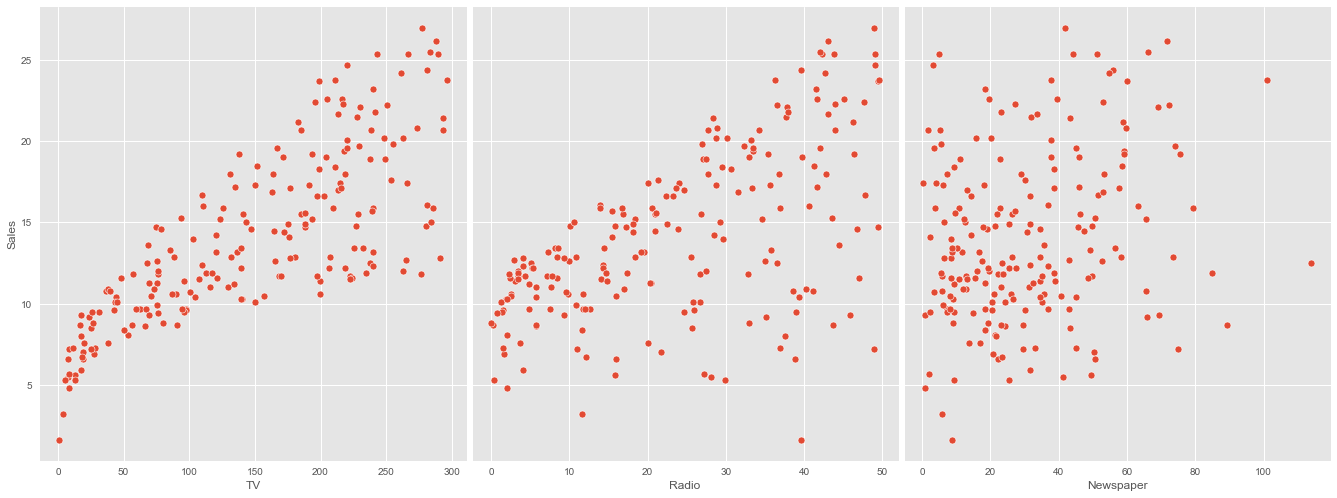

In [66]:
fig = sns.pairplot(df, x_vars=['TV', 'Radio', 'Newspaper'], y_vars='Sales', height=7, aspect=0.9);

It is clearly seen that there is a strong linear correlation between TV and the sales while there is a less so between Radio and the sales and almost no correlation between Newspaper and the sales. 

# Multiple Linear Regression Model

In [67]:
from sklearn.linear_model import LinearRegression

X = df[['TV', 'Radio', 'Newspaper']]
y = df['Sales']

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [68]:
list(zip(['TV', 'Radio', 'Newspaper'], np.round(model.coef_, 3)))

[('TV', 0.046), ('Radio', 0.189), ('Newspaper', -0.001)]

Radio overtakes TV with respect to sales when all the features are taken into consideration. We also can see that Newspaper has apparently no effect on the sales.

The below map display the correlation between the features and the sales.

<AxesSubplot:>

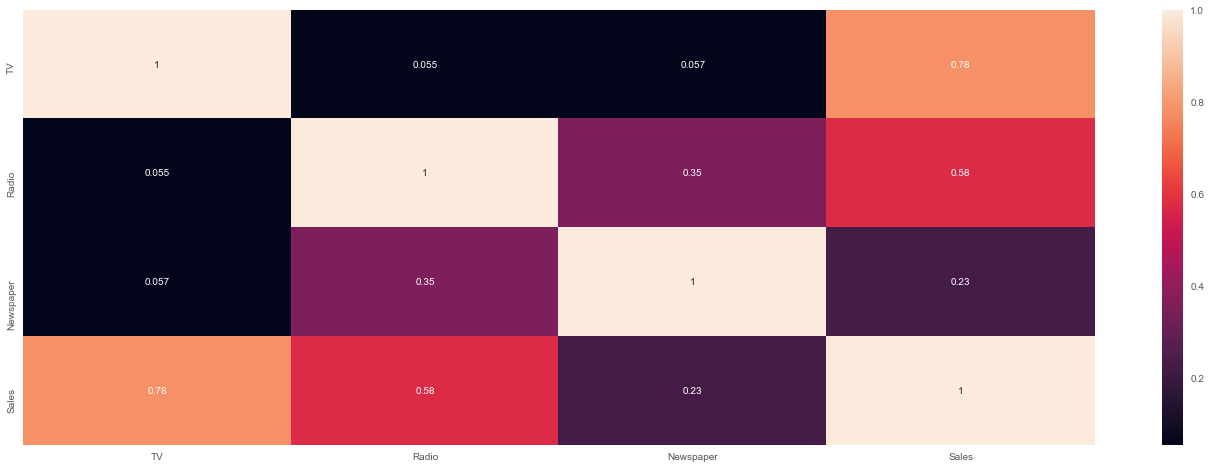

In [69]:
sns.heatmap(df.corr(), annot=True)

# Feature Selection

In [70]:
from sklearn.metrics import r2_score

score_1 = model.score(X[['TV', 'Radio', 'Newspaper']], y) 

model_2 = LinearRegression().fit(X[['TV', 'Radio']], y)
score_2 = model_2.score(X[['TV', 'Radio']], y)

print(f"R^2 score for TV and Radio is {np.round(score_2,6)} while the R^2 score for all features included is {np.round(score_1, 6)}")

R^2 score for TV and Radio is 0.897194 while the R^2 score for all features included is 0.897211


The tiny difference between the two R^2 scores encourages the idea of dropping Newspaper from our model.

# Train/Test Split and Metrics

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)

In [82]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(160, 3)
(40, 3)
(160,)
(40,)


In [87]:
train_model = LinearRegression()
train_model.fit(X_train, y_train)

train_model.score(X_train, y_train)

0.8950173935154758

In [88]:
train_pred = train_model.predict(X_test)

# RMSE metrics
rmse = np.sqrt(np.sum((train_pred - y_test)**2)/len(y_test))

# R^2 metrics
r_squared = r2_score(y_test, train_pred)

print("the RMSE and R^2 values for the model containing all features are {} and {}, respectively.".format(np.round(rmse, 5), np.round(r_squared, 5)))

the RMSE and R^2 values for the model containing all features are 1.56018 and 0.90526, respectively.


Evaluate RMSE and R^2 for the model Radio feature excluded

In [89]:
X = df[['TV', 'Radio']]
y = df.Sales

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)

excluded_model = LinearRegression()
excluded_model.fit(X_train, y_train)

score = excluded_model.score(X_test, y_test)
excluded_pred = train_model.predict(X_test)
# RMSE metrics
rmse = np.sqrt(np.sum((excluded_pred - y_test)**2)/len(y_test))

# R^2 metrics
r_squared = r2_score(y_test, excluded_pred)

print(score)
print("the RMSE and R^2 values for the model containing only the features TV and Radio are {} and {}, respectively.".format(np.round(rmse, 5), np.round(r_squared, 5)))

0.9357479900467168
the RMSE and R^2 values for the model containing only the features TV and Radio are 1.42969 and 0.93955, respectively.


Display the Prediction Error

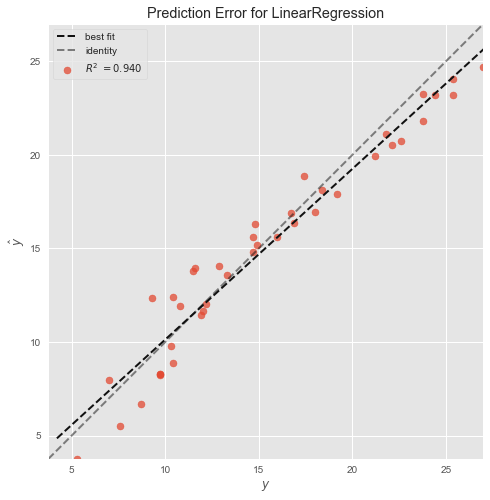

In [90]:
from yellowbrick.regressor import PredictionError, ResidualsPlot

visualizer = PredictionError(train_model)
visualizer.score(X_test, y_test)
visualizer.poof();

# Interaction Effect (Synergy)

Create a new feature that will allow us to find a better model that reflects the interaction between TV and Radio

In [91]:
df['Interaction'] = df.TV * df.Radio

X = df[['TV', 'Radio', 'Interaction']]
y = df.Sales

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

interaction_model = LinearRegression()
interaction_model.fit(X_train, y_train)

interaction_model.score(X_test, y_test)

0.961821802934317

In [92]:
interaction_pred = interaction_model.predict(X_test)
# RMSE metrics
rmse = np.sqrt(np.sum((interaction_pred - y_test)**2)/len(y_test))

# R^2 metrics
r_squared = r2_score(y_test, interaction_pred)

print(rmse, r_squared)

0.9809291728872976 0.961821802934317


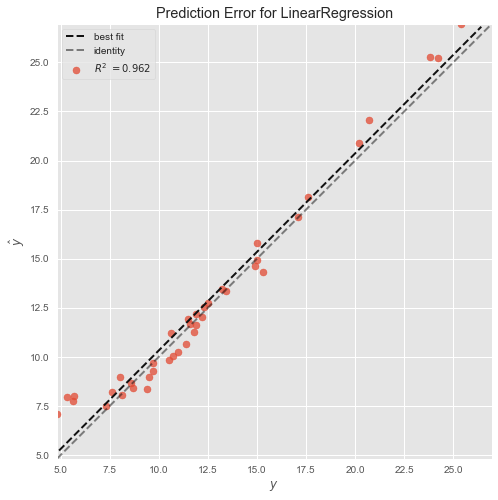

In [93]:
from yellowbrick.regressor import PredictionError, ResidualsPlot

visualizer = PredictionError(interaction_model)
visualizer.score(X_test, y_test)
visualizer.poof();

#### R^2 has almost reached 98% and RMSE has decreased by about 50%!

In [94]:
# R^2 metrics formula
score = 1 - np.sum((y_test-interaction_pred)**2)/np.sum((y_test-np.mean(y_test))**2)